<a href="https://colab.research.google.com/github/kiannakazemi/Magic_Gamma_Telescope/blob/main/magic_gamma_telescope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAGIC Gamma Telescope

In a gamma telescope, high-energy particles hit the telescope. A detector records specific patterns of light hitting the telescope. By analyzing the properties of these patterns, we are going to predict the type of particle that caused the radiation, whether it was a gamma particle or a hadron.

Magic dataset: https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope


**Attribute Information:**

    1.  fLength        # major axis of ellipse [mm]
    2.  fWidth:        # minor axis of ellipse [mm]
    3.  fSize:         # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:         # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:        # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:         # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:       # 3rd root of third moment along major axis  [mm]
    8.  fM3Trans:      # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:        # angle of major axis with vector to origin [deg]
    10. fDist:         # distance from origin to center of ellipse [mm]
    11. class: g,h     # gamma (signal), hadron (background)

   g = gamma (signal):     12332
   
   h = hadron (background): 6688

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#set attribute names as column labels
cols = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

df = pd.read_csv('magic04.data', names = cols)

#since there is no inherit order for column 'class', we use one-hot encoding: gamma -> [1, 0] hadron -> [0, 1]
df['class'] = (df['class'] == 'g').astype(int) # set gamma to 1 & hadron to 0, for the computer's understanding

To have a better understanding of our data, let's generate histograms to visualize the distribution of different features among the classes (gamma and hadron).

In [ ]:
for label in cols[:-1]:
  plt.hist(df[df['class']==1][label], color = 'blue', label = 'gamma', alpha = 0.7, density = True)
  plt.hist(df[df['class']==0][label], color = 'red', label = 'hadron', alpha = 0.7, density = True)
  plt.title(label)
  plt.ylabel('Probability')
  plt.xlabel(label)
  plt.legend()
  plt.show()
  print()  # Adding a new line after each plot

**Train, validation & test datasets**

Our data will be divided into three sets: 60% for training, 20% for validation, and the remaining 20% for testing.

In [ ]:
train, validation, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

If we inspect our data, there are significant variations in column values, which may affect our results. Therefore, we'll scale the data relative to each column's standard deviation for better consistency.


In [ ]:
def scale_dataset(dataframe, oversample = False):
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  x = scaler.fit_transform(x)

  if oversample:
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x, y)

  data = np.hstack((x, np.reshape(y, (len(y), 1))))

  return data, x, y

In [ ]:
print("The number of gammas in the training dataset is: ", len(train[train['class'] == 1]))
print("The number of hadrons in the training dataset is: ", len(train[train['class'] == 0]))

The number of gammas in the training dataset is:  7395
The number of hadrons in the training dataset is:  4017


As we can see, in our training dataset there are around 7000 gammas, but only about 4000 hadrons. This significant imbalance might become an issue, therefore, we're going to oversample the dataset.

In [ ]:
 train, x_train, y_train = scale_dataset(train, oversample=True)
validation, x_validation, y_validation = scale_dataset(validation, oversample=False)
test, x_test, y_test = scale_dataset(test, oversample=False)

**K-nearest neighbors**


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [ ]:
k = 3 #number of neighbors utilized to determine the label
knn_model = KNeighborsClassifier(n_neighbors = k)
knn_model.fit(x_train, y_train)
y_prediction = knn_model.predict(x_test)

Now, we are going to use the classification_report function to generate a text report.

Precision: Out of all the instances our algorithm has labeled as 'hadron,' only 0.74 are actually hadrons, and out of all the instances labeled as 'gamma,' only 0.86 are actually gammas.

Recall: Out of all the actual hadrons, we correctly identify 0.73 of them, and out of all the actual gammas, we correctly identify 0.86 of them.

For a better understanding, we can study the f1-score, which is a combination of precision and recall.

As we can see, we achieve an accuracy of 0.82, which is considered acceptable.

In [ ]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1374
           1       0.85      0.86      0.85      2430

    accuracy                           0.81      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.81      0.81      0.81      3804



**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

Considering the superior performance of KNN, the total accuracy of 0.73 is rather unexpected.

In [ ]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
y_prediction = nb_model.predict(x_test)
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.71      0.40      0.51      1374
           1       0.73      0.91      0.81      2430

    accuracy                           0.72      3804
   macro avg       0.72      0.65      0.66      3804
weighted avg       0.72      0.72      0.70      3804



**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

As we can see, this algorithm works slightly better than Naive Bayes, but it is not as good as KNN.

In [ ]:
logreg_model = LogisticRegression()
logreg_model = logreg_model.fit(x_train, y_train)
y_pred = logreg_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1374
           1       0.85      0.84      0.84      2430

    accuracy                           0.80      3804
   macro avg       0.78      0.78      0.78      3804
weighted avg       0.80      0.80      0.80      3804



**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

As wee can see, the accuracy achieved by this algorithm surpasses other algorithms.


In [ ]:
svm_model = SVC()
svm_model = svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1374
           1       0.89      0.90      0.89      2430

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



**Neural Network**

In [ ]:
import tensorflow as tf

In [ ]:
def train_model(x_train, y_train, num_nodes, dropout_probability, learning_rate, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_probability),
      tf.keras.layers.Dense(num_nodes, activation = 'relu'),
      tf.keras.layers.Dropout(dropout_probability),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

  nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])

  #Training the model
  history = nn_model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = validation, verbose=0)

  return nn_model, history


In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary Crossentropy')
  plt.legend()
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  plt.legend()
  ax2.grid(True)

  plt.show()

As we can see, the algorithm performs better with 64 nodes, surpassing the accuracy of other algorithms.

Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 32


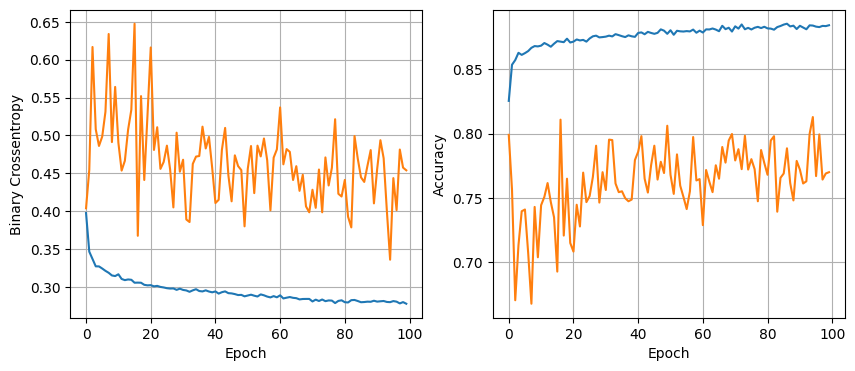

119/119 [==============================] - 0s 2ms/step - loss: 0.3128 - accuracy: 0.8770
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 64


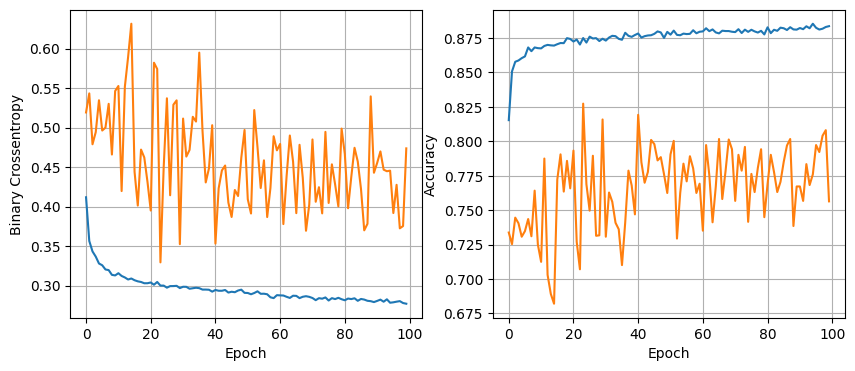

119/119 [==============================] - 0s 2ms/step - loss: 0.3225 - accuracy: 0.8701
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 128


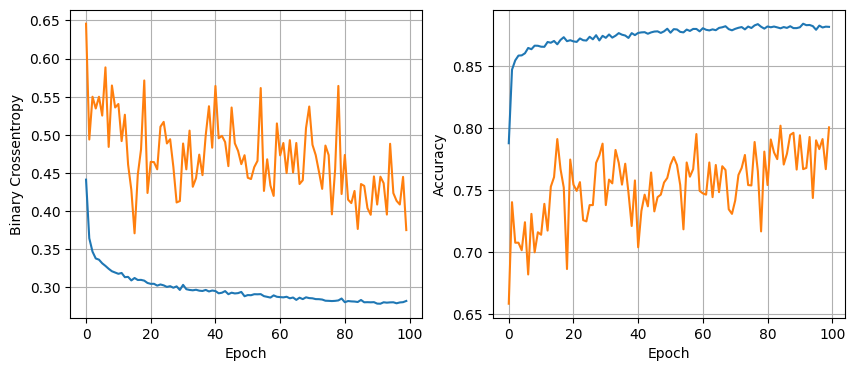

119/119 [==============================] - 0s 2ms/step - loss: 0.3228 - accuracy: 0.8699
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 32


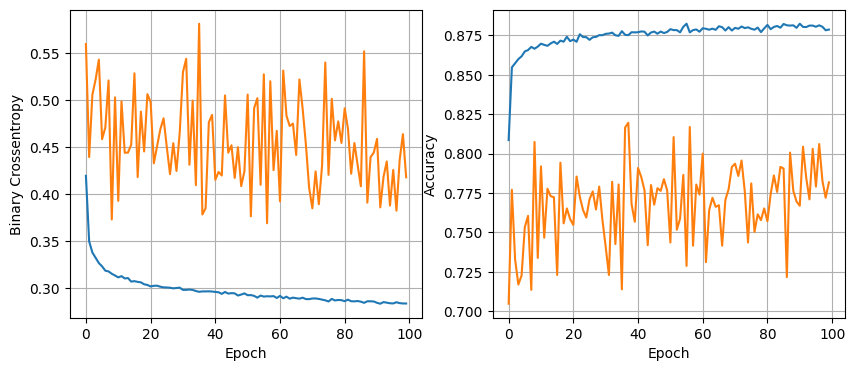

119/119 [==============================] - 0s 2ms/step - loss: 0.3164 - accuracy: 0.8738
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 64


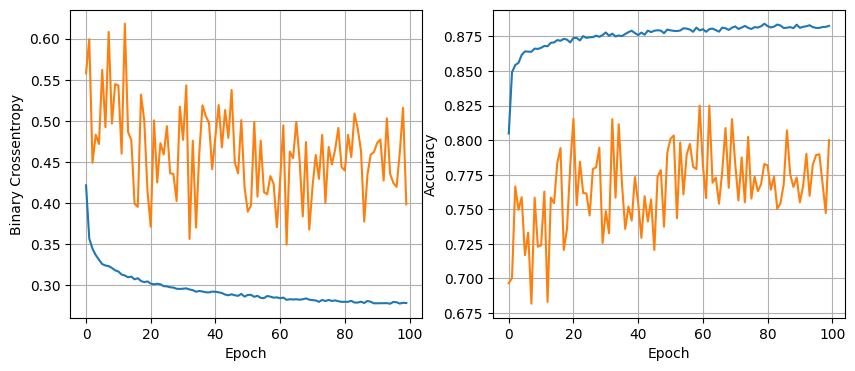

119/119 [==============================] - 0s 2ms/step - loss: 0.3215 - accuracy: 0.8680
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 128


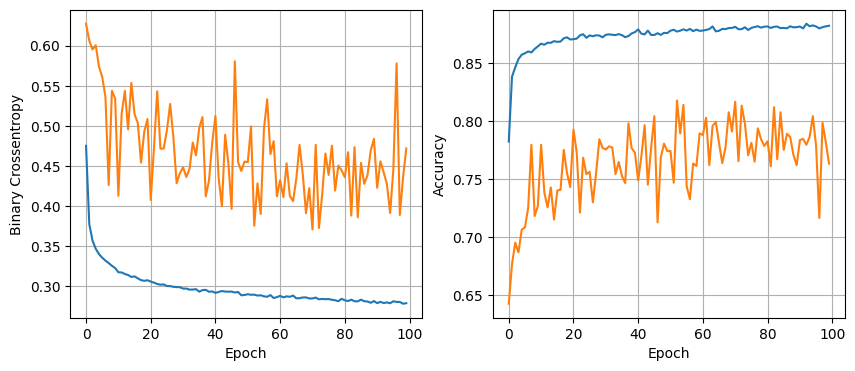

119/119 [==============================] - 0s 3ms/step - loss: 0.3030 - accuracy: 0.8785
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 32


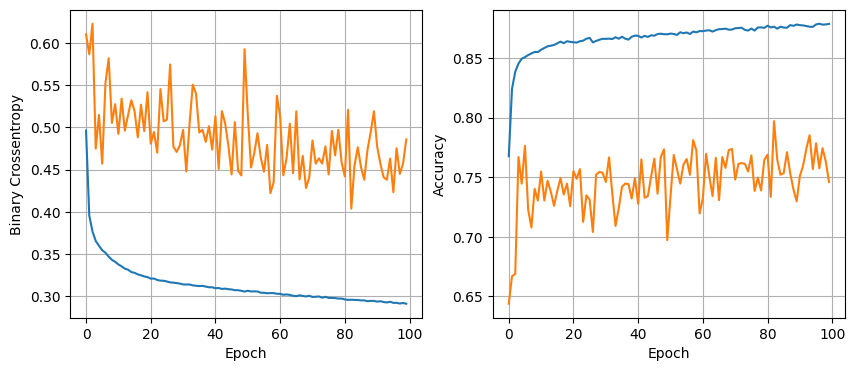

119/119 [==============================] - 0s 2ms/step - loss: 0.3069 - accuracy: 0.8701
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 64


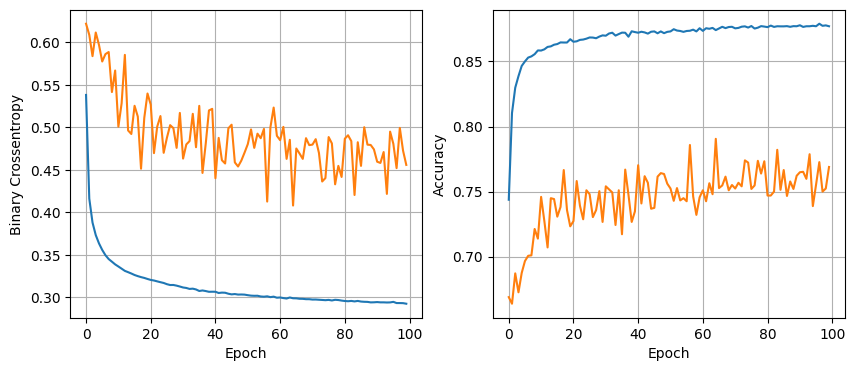

119/119 [==============================] - 0s 2ms/step - loss: 0.3065 - accuracy: 0.8743
Number of nodes: (16,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 128


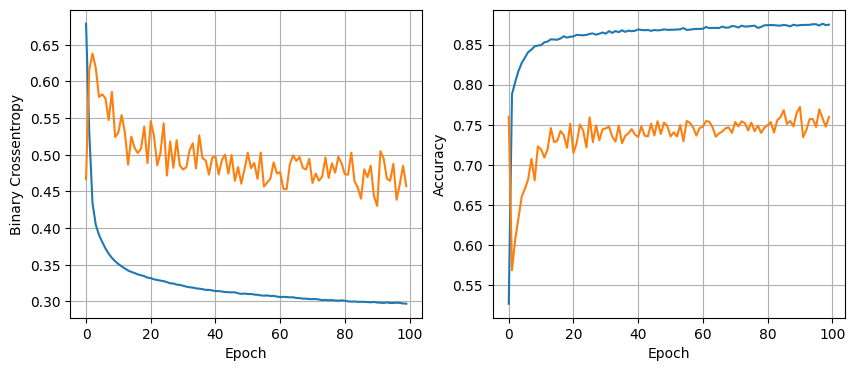

119/119 [==============================] - 0s 2ms/step - loss: 0.3127 - accuracy: 0.8696
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 32


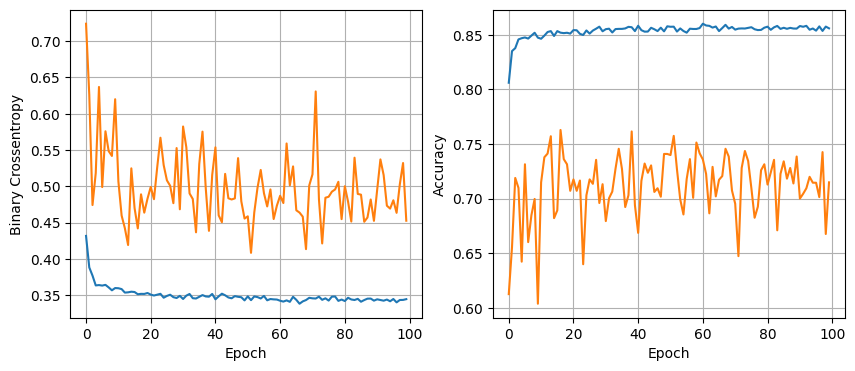

119/119 [==============================] - 0s 2ms/step - loss: 0.3214 - accuracy: 0.8722
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 64


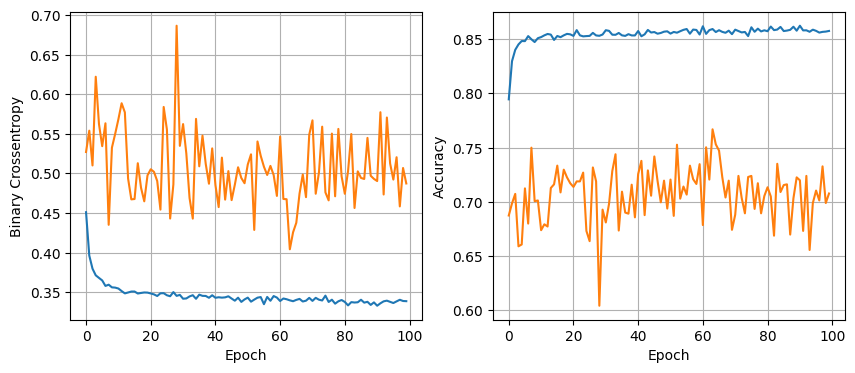

119/119 [==============================] - 0s 2ms/step - loss: 0.3171 - accuracy: 0.8751
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 128


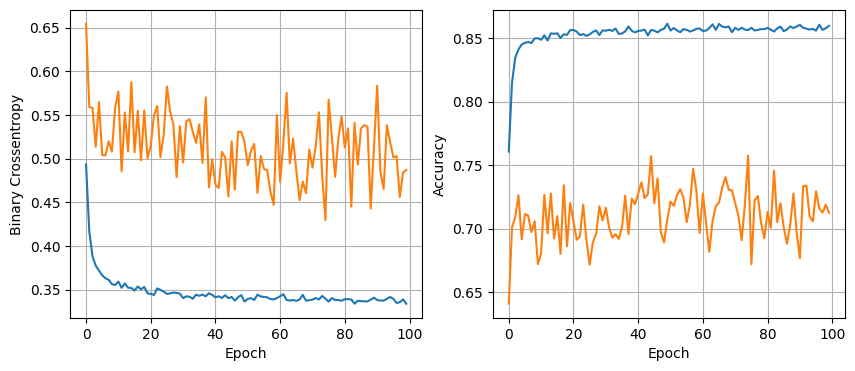

119/119 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.8728
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 32


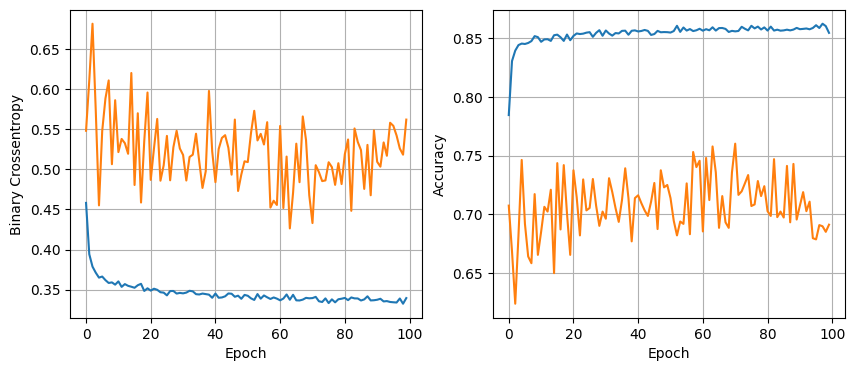

119/119 [==============================] - 0s 2ms/step - loss: 0.3184 - accuracy: 0.8649
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 64


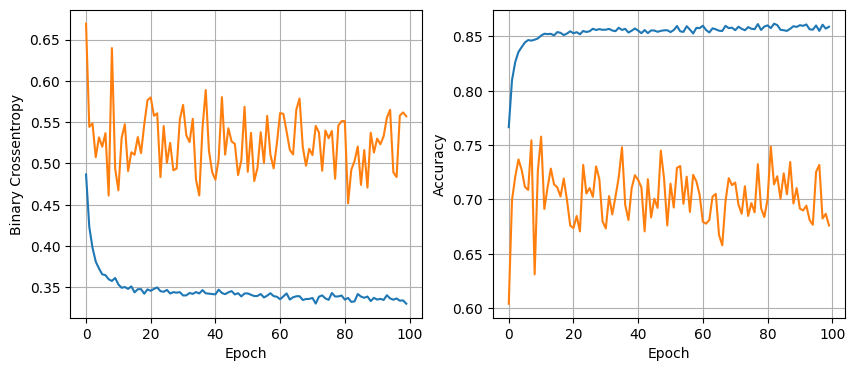

119/119 [==============================] - 0s 2ms/step - loss: 0.3166 - accuracy: 0.8657
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 128


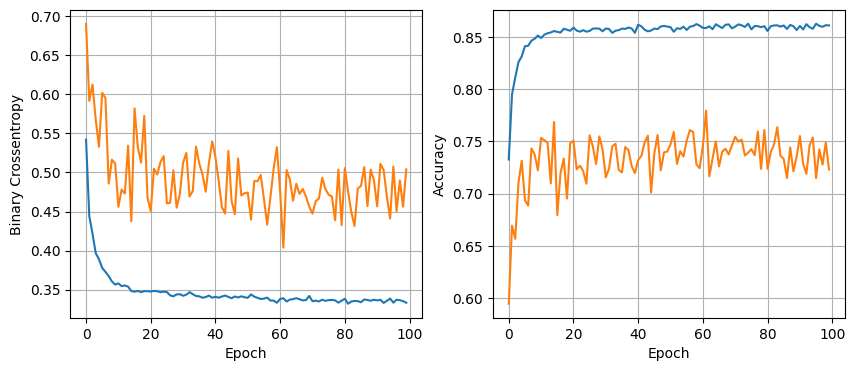

119/119 [==============================] - 0s 2ms/step - loss: 0.3085 - accuracy: 0.8762
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 32


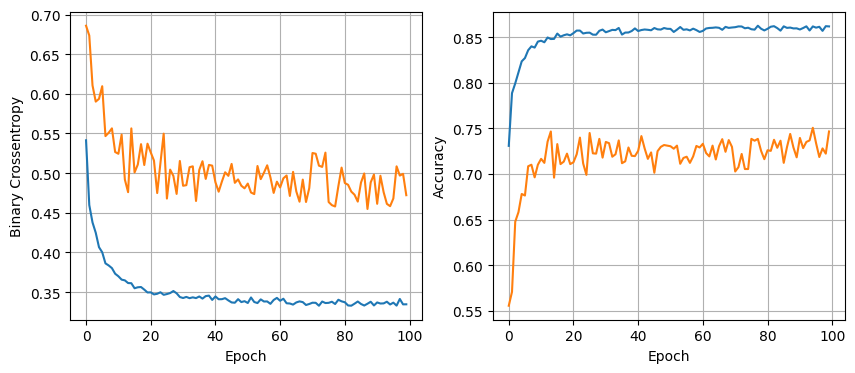

119/119 [==============================] - 0s 2ms/step - loss: 0.3132 - accuracy: 0.8720
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 64


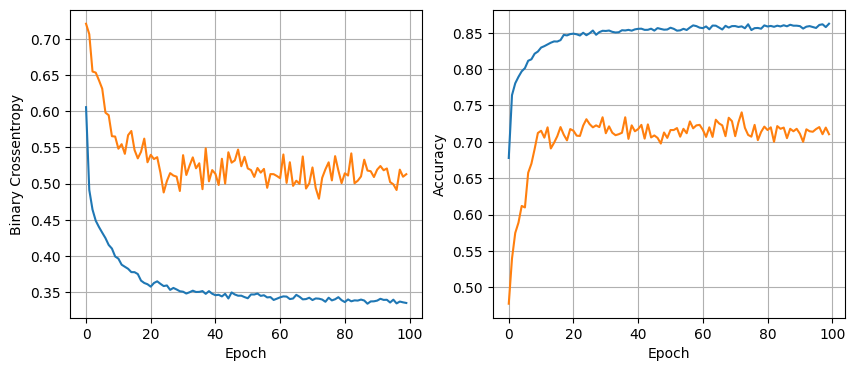

119/119 [==============================] - 0s 3ms/step - loss: 0.3117 - accuracy: 0.8730
Number of nodes: (16,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 128


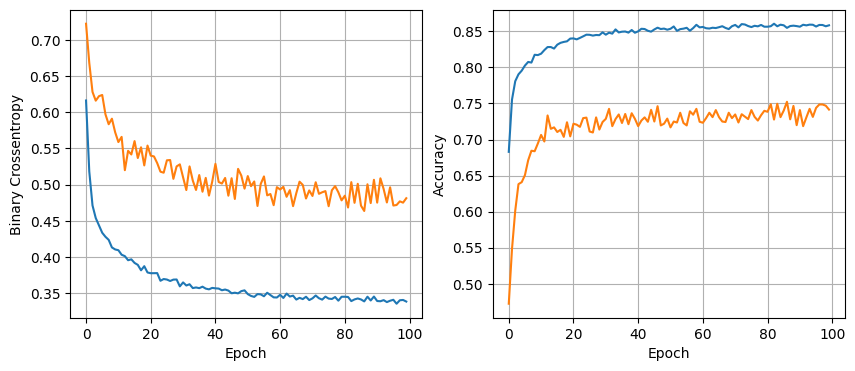

119/119 [==============================] - 0s 3ms/step - loss: 0.3180 - accuracy: 0.8712
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 32


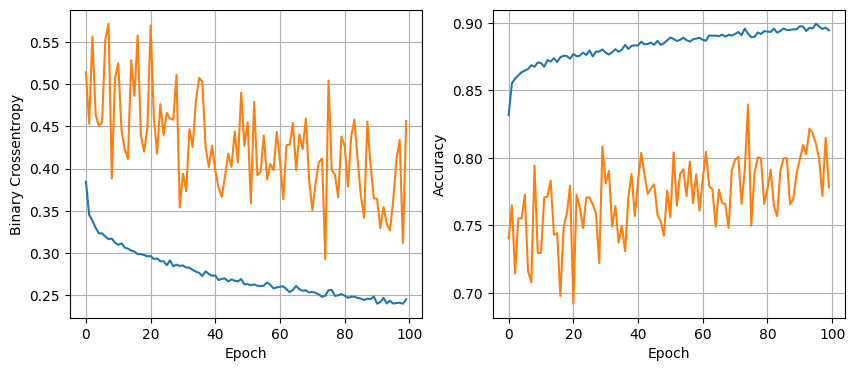

119/119 [==============================] - 0s 3ms/step - loss: 0.3818 - accuracy: 0.8701
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 64


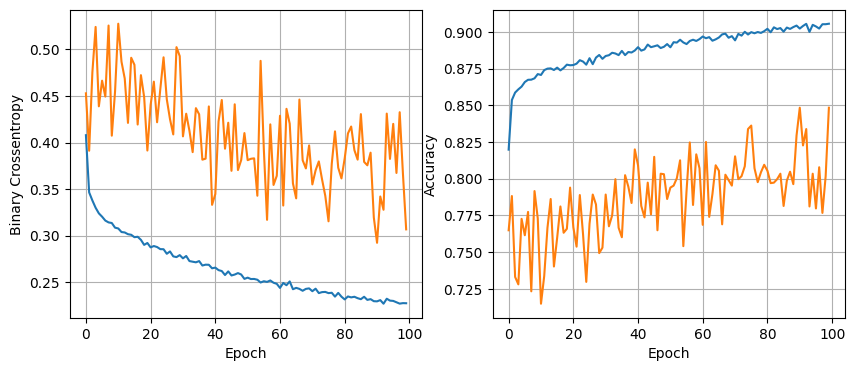

119/119 [==============================] - 0s 2ms/step - loss: 0.4023 - accuracy: 0.8636
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 128


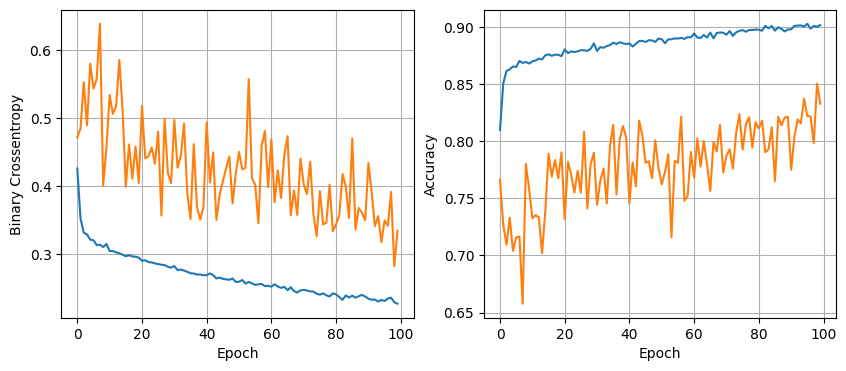

119/119 [==============================] - 0s 3ms/step - loss: 0.3741 - accuracy: 0.8609
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 32


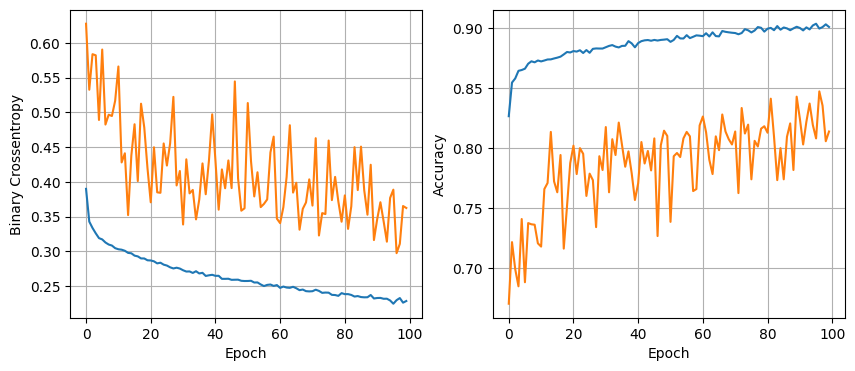

119/119 [==============================] - 0s 3ms/step - loss: 0.3670 - accuracy: 0.8667
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 64


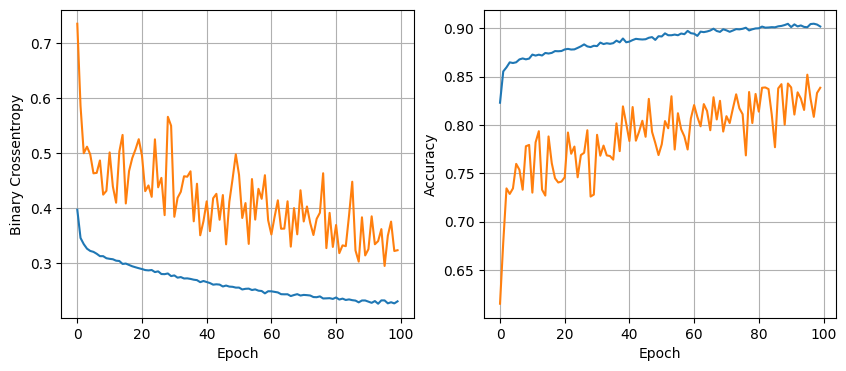

119/119 [==============================] - 0s 3ms/step - loss: 0.3327 - accuracy: 0.8720
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 128


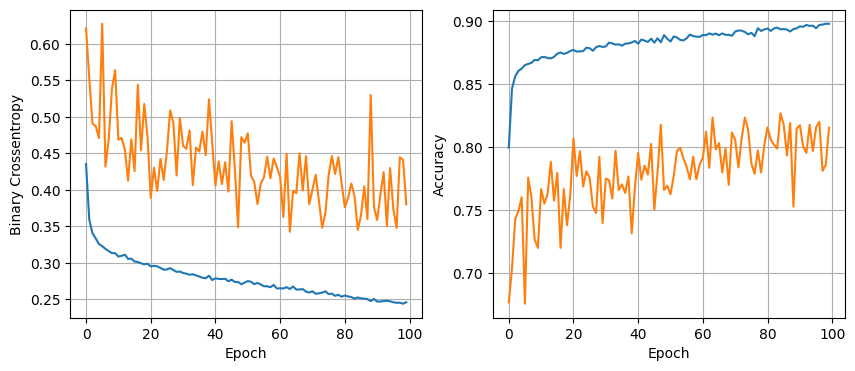

119/119 [==============================] - 0s 3ms/step - loss: 0.3311 - accuracy: 0.8757
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 32


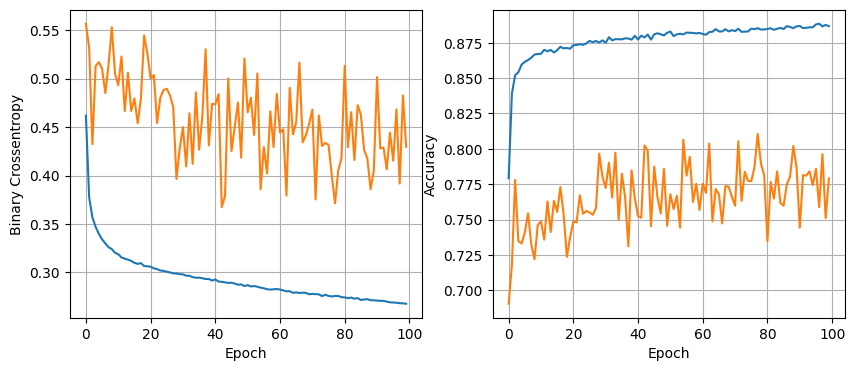

119/119 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.8730
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 64


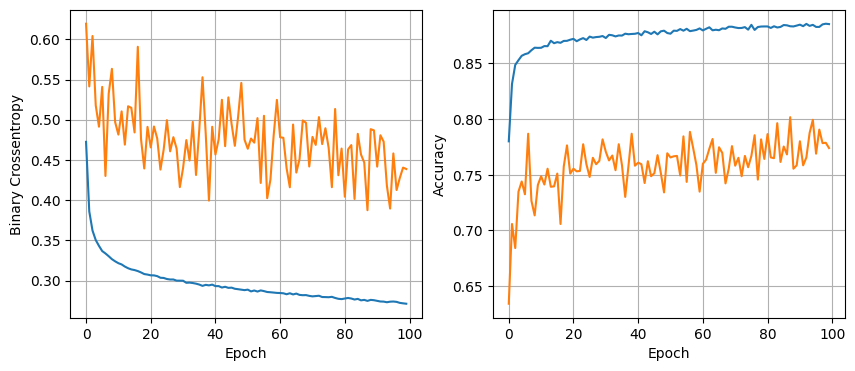

119/119 [==============================] - 0s 3ms/step - loss: 0.3051 - accuracy: 0.8770
Number of nodes: (32,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 128


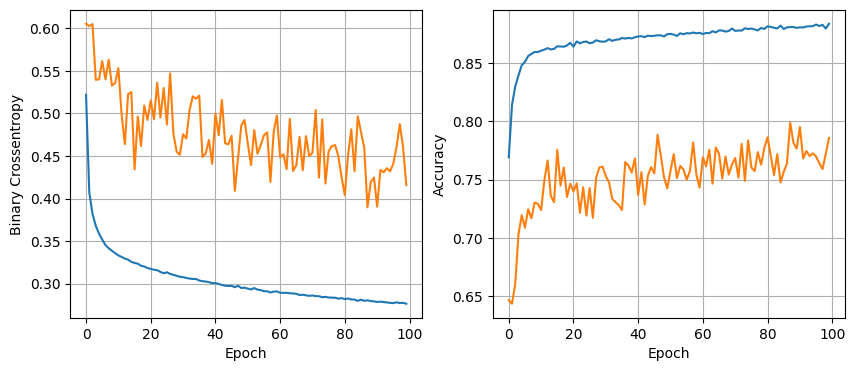

119/119 [==============================] - 0s 3ms/step - loss: 0.3128 - accuracy: 0.8709
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 32


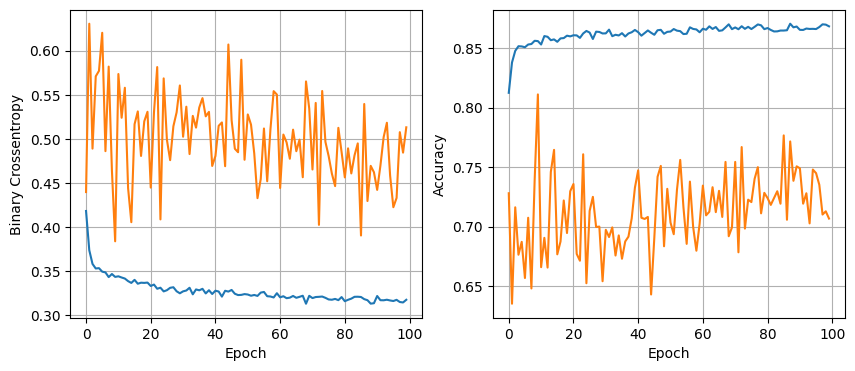

119/119 [==============================] - 0s 3ms/step - loss: 0.3062 - accuracy: 0.8733
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 64


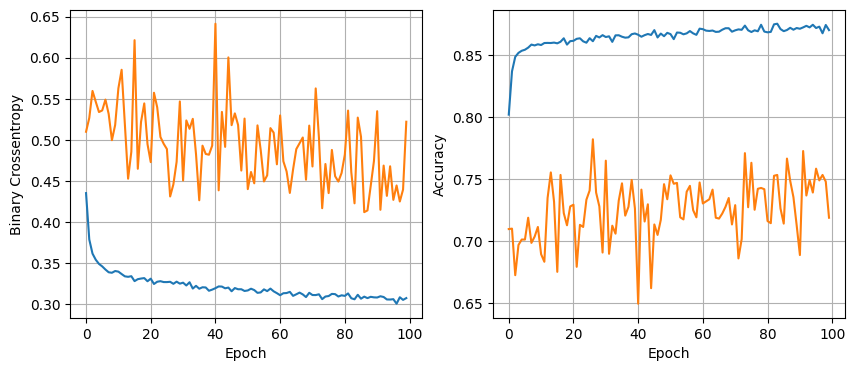

119/119 [==============================] - 0s 3ms/step - loss: 0.3055 - accuracy: 0.8780
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 128


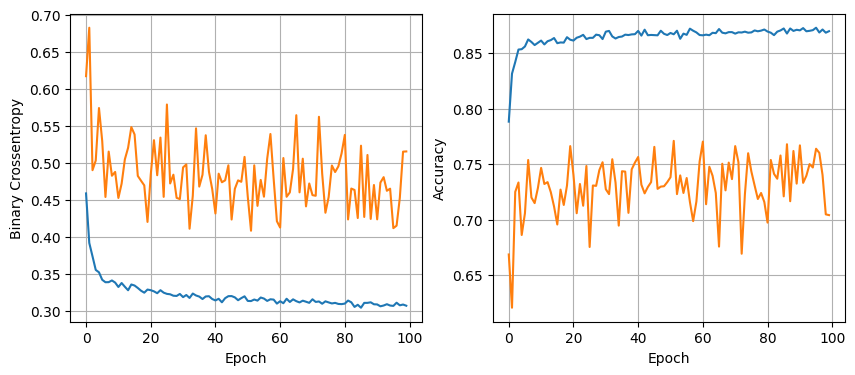

119/119 [==============================] - 0s 3ms/step - loss: 0.3002 - accuracy: 0.8751
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 32


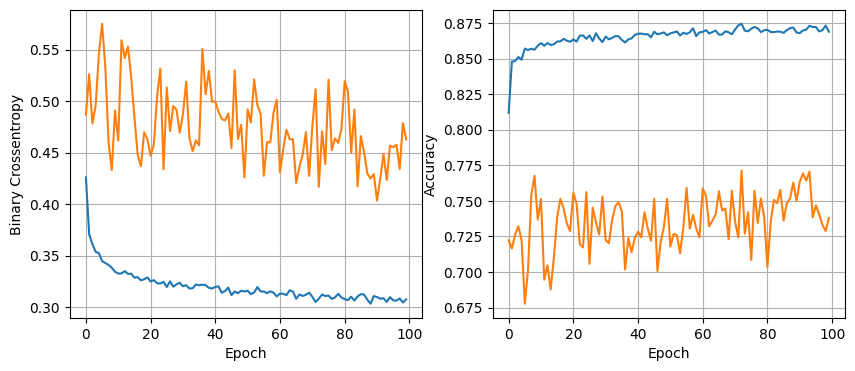

119/119 [==============================] - 0s 4ms/step - loss: 0.2998 - accuracy: 0.8793
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 64


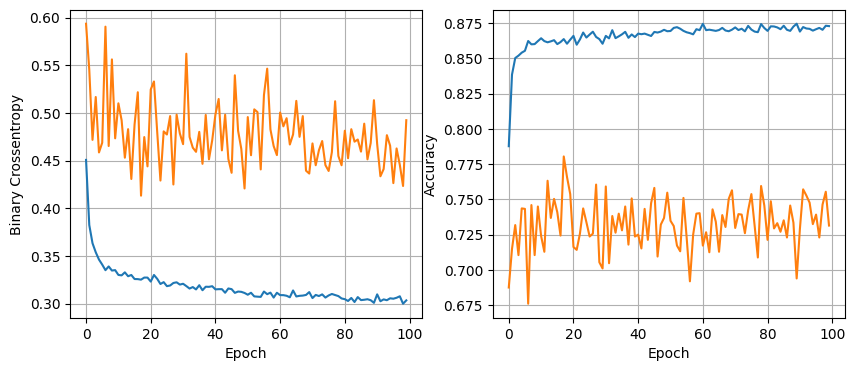

119/119 [==============================] - 0s 3ms/step - loss: 0.2942 - accuracy: 0.8783
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 128


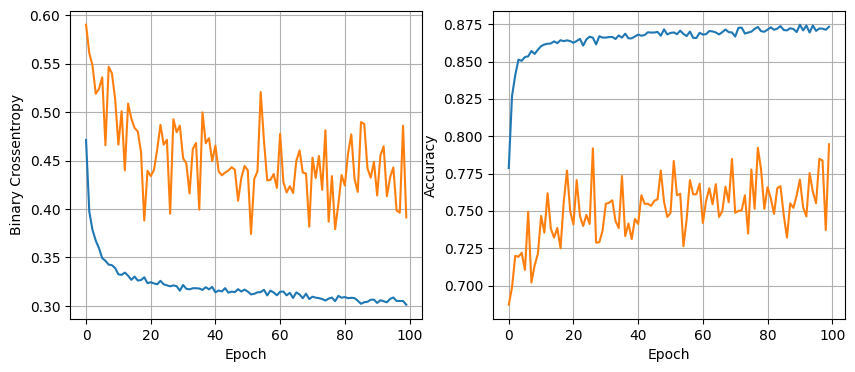

119/119 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.8767
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 32


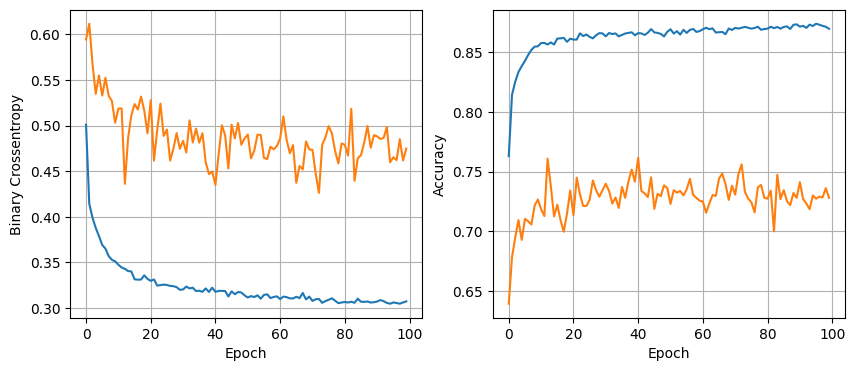

119/119 [==============================] - 0s 3ms/step - loss: 0.2966 - accuracy: 0.8791
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 64


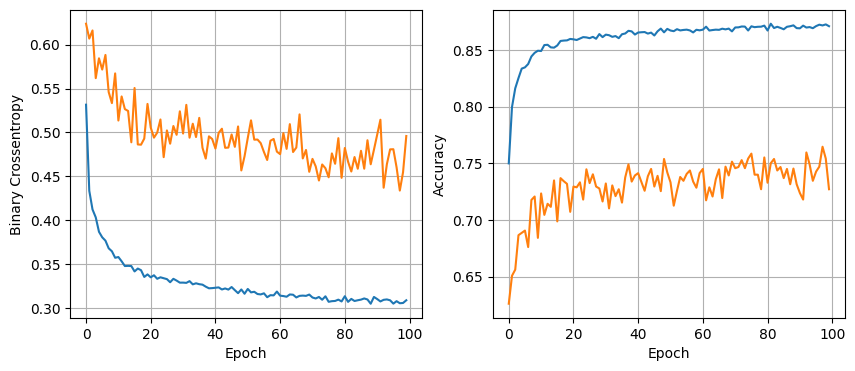

119/119 [==============================] - 0s 3ms/step - loss: 0.2947 - accuracy: 0.8772
Number of nodes: (32,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 128


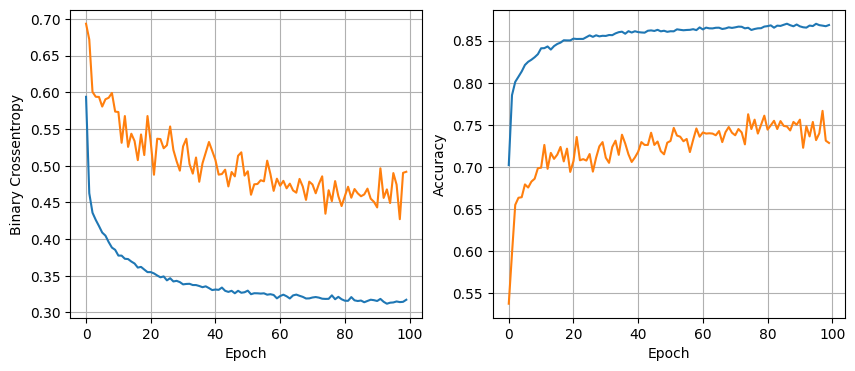

119/119 [==============================] - 0s 4ms/step - loss: 0.2969 - accuracy: 0.8778
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 32


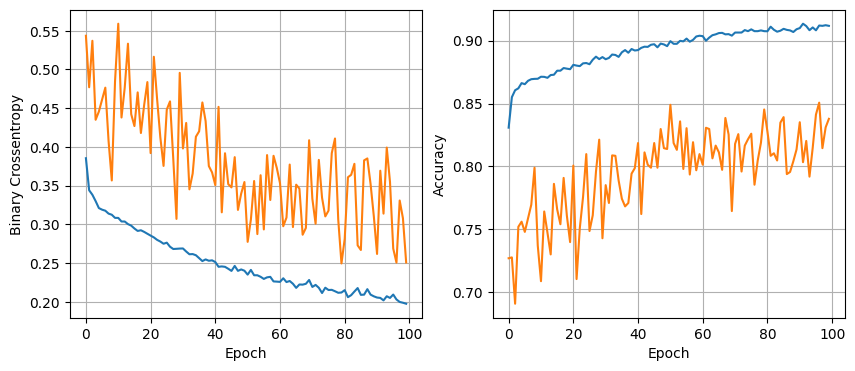

119/119 [==============================] - 0s 3ms/step - loss: 0.4753 - accuracy: 0.8552
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 64


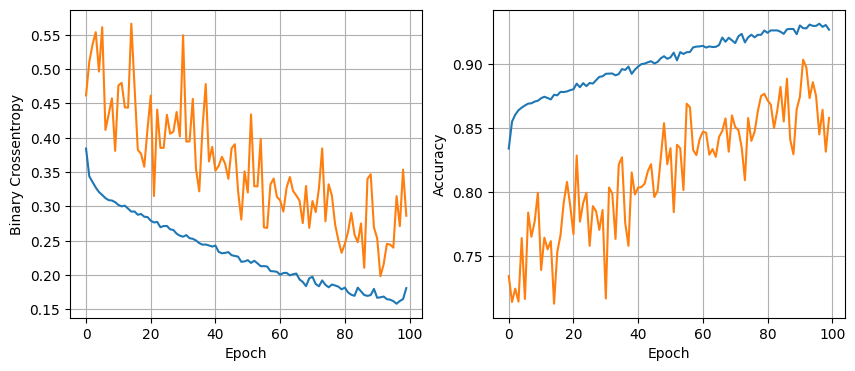

119/119 [==============================] - 0s 3ms/step - loss: 0.4931 - accuracy: 0.8512
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.01 Batch size: 128


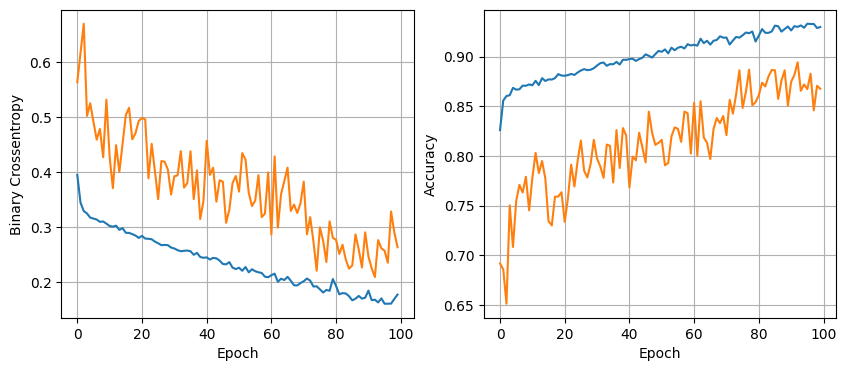

119/119 [==============================] - 0s 3ms/step - loss: 0.5114 - accuracy: 0.8575
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 32


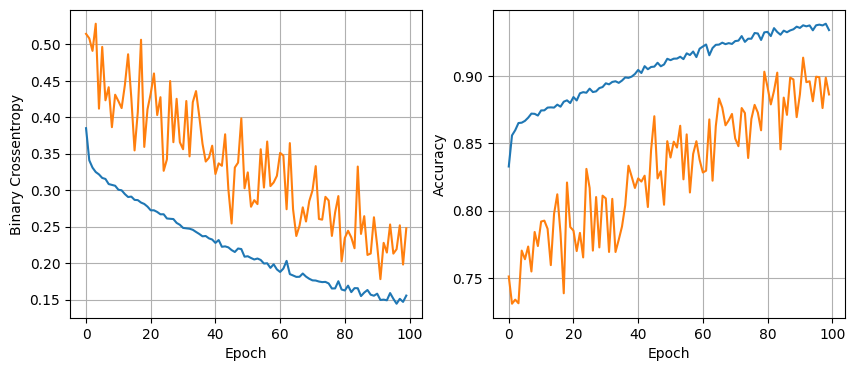

119/119 [==============================] - 0s 3ms/step - loss: 0.5288 - accuracy: 0.8617
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 64


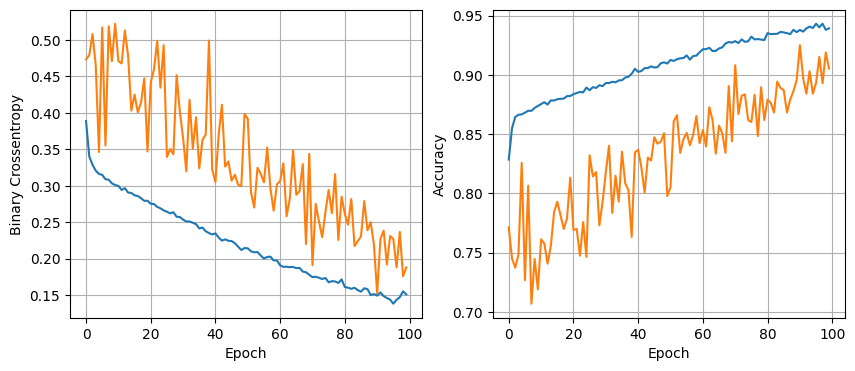

119/119 [==============================] - 0s 3ms/step - loss: 0.5361 - accuracy: 0.8460
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.005 Batch size: 128


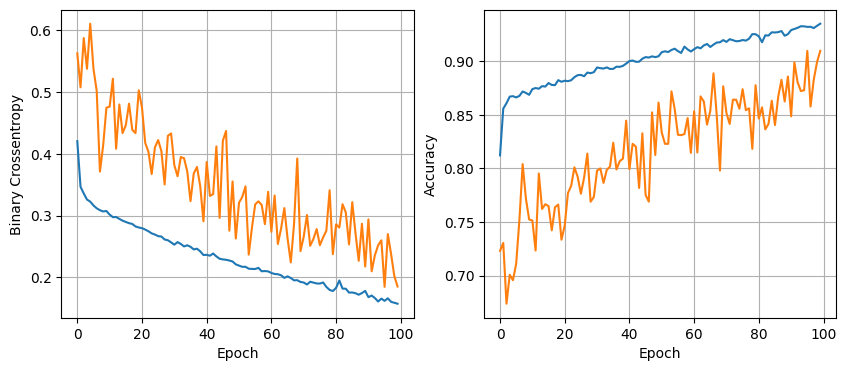

119/119 [==============================] - 0s 3ms/step - loss: 0.4624 - accuracy: 0.8594
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 32


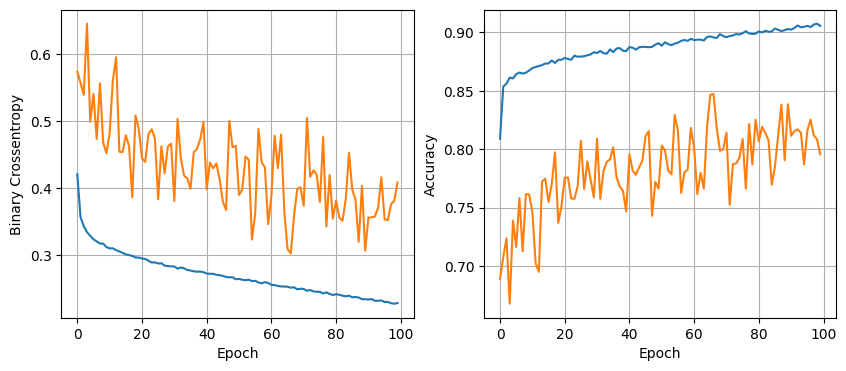

119/119 [==============================] - 0s 3ms/step - loss: 0.3260 - accuracy: 0.8722
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 64


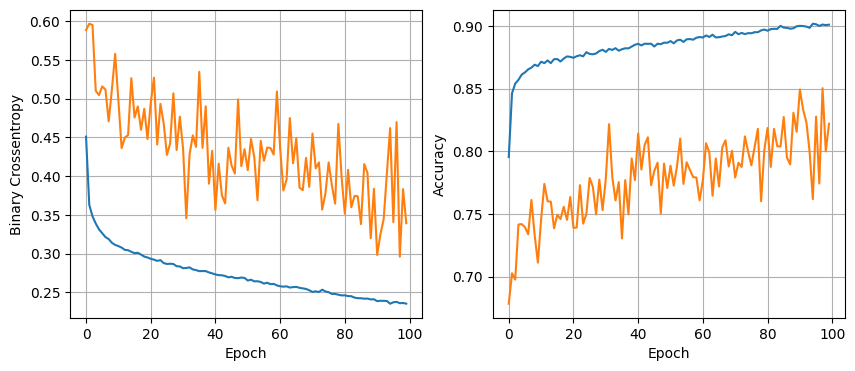

119/119 [==============================] - 0s 3ms/step - loss: 0.3171 - accuracy: 0.8693
Number of nodes: (64,), Dropout probability: 0 Learning_rate: 0.001 Batch size: 128


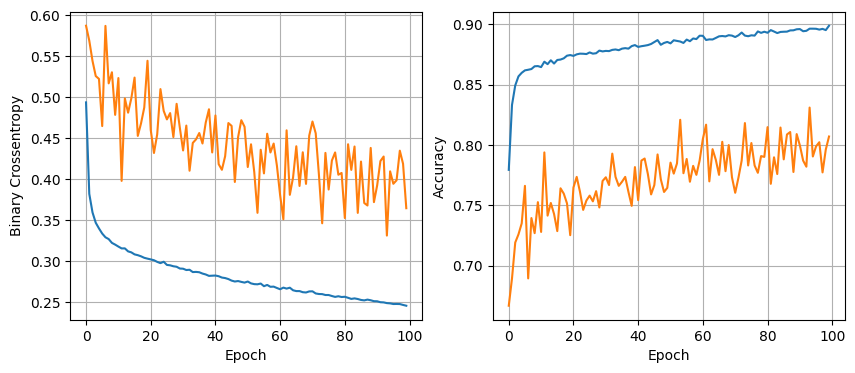

119/119 [==============================] - 0s 3ms/step - loss: 0.3143 - accuracy: 0.8715
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 32


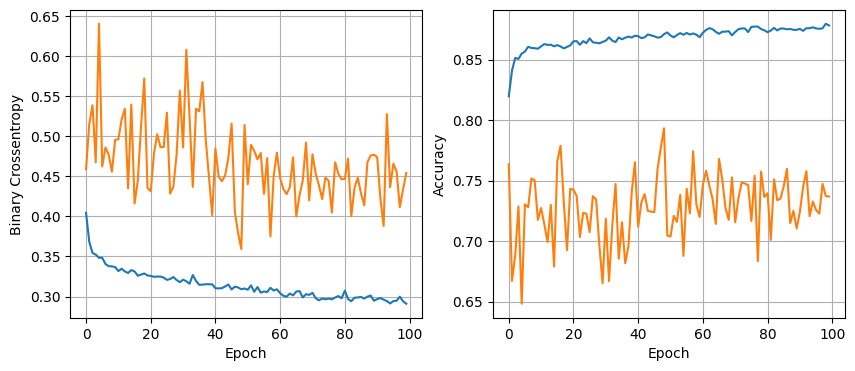

119/119 [==============================] - 0s 3ms/step - loss: 0.3074 - accuracy: 0.8754
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 64


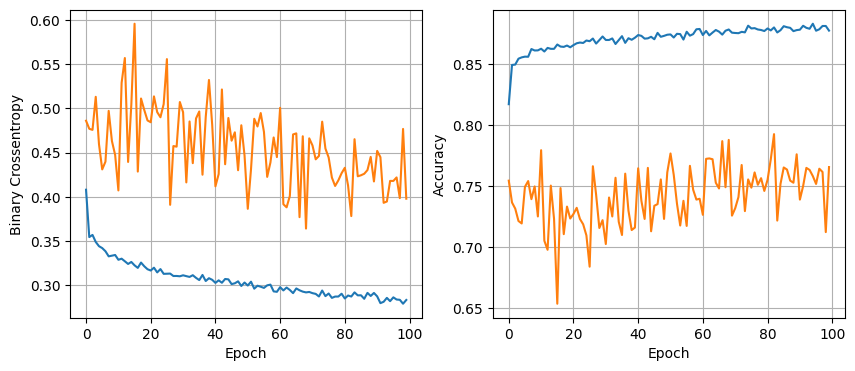

119/119 [==============================] - 0s 3ms/step - loss: 0.3023 - accuracy: 0.8780
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.01 Batch size: 128


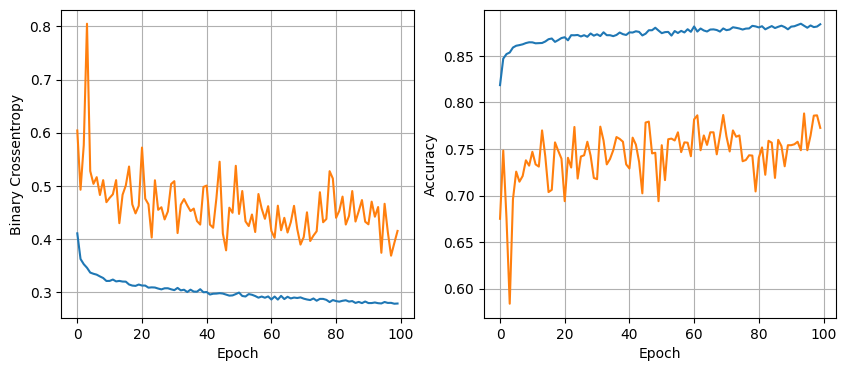

119/119 [==============================] - 0s 3ms/step - loss: 0.2944 - accuracy: 0.8862
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 32


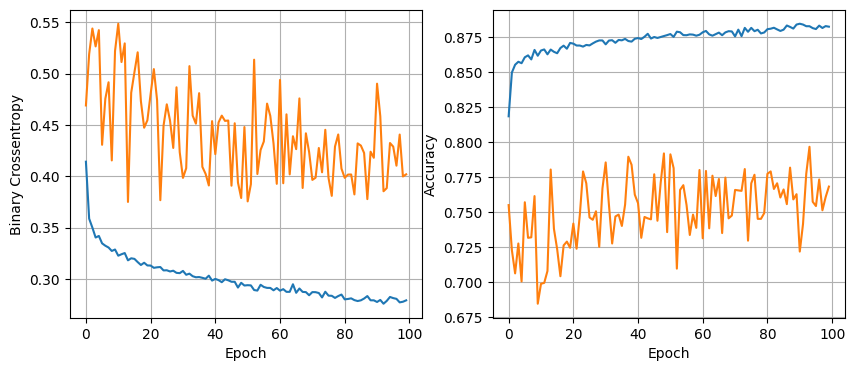

119/119 [==============================] - 0s 3ms/step - loss: 0.2978 - accuracy: 0.8825
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 64


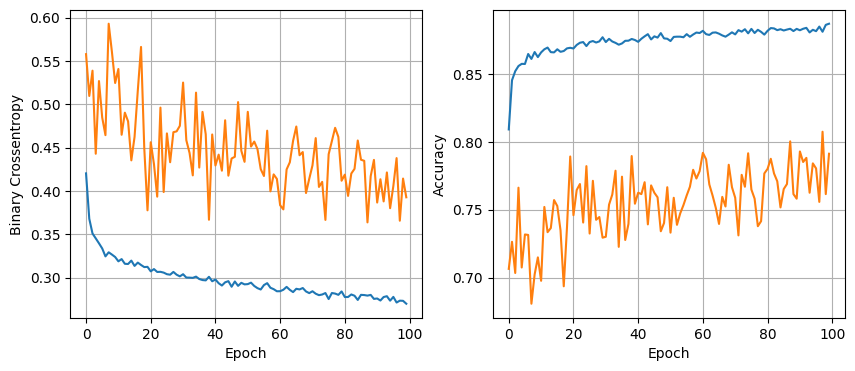

119/119 [==============================] - 0s 3ms/step - loss: 0.2932 - accuracy: 0.8807
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.005 Batch size: 128


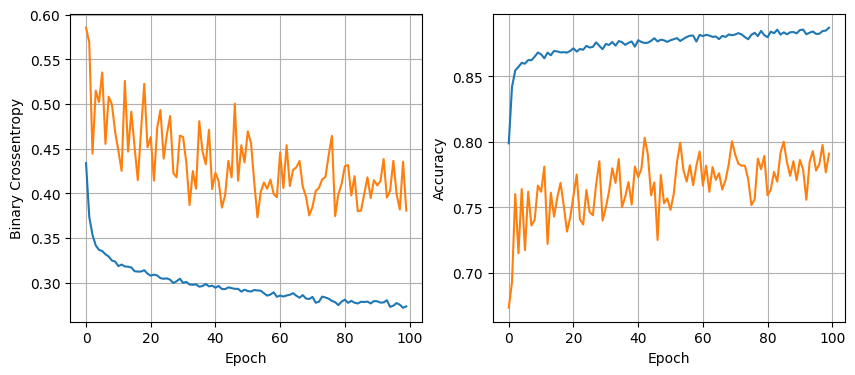

119/119 [==============================] - 0s 2ms/step - loss: 0.2969 - accuracy: 0.8809
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 32


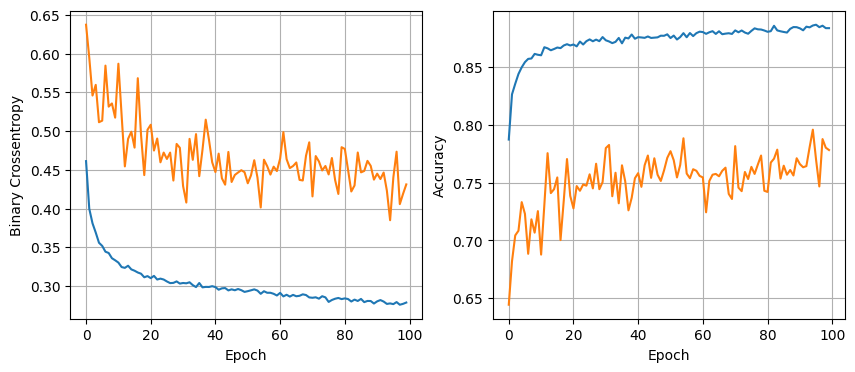

119/119 [==============================] - 0s 3ms/step - loss: 0.2922 - accuracy: 0.8835
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 64


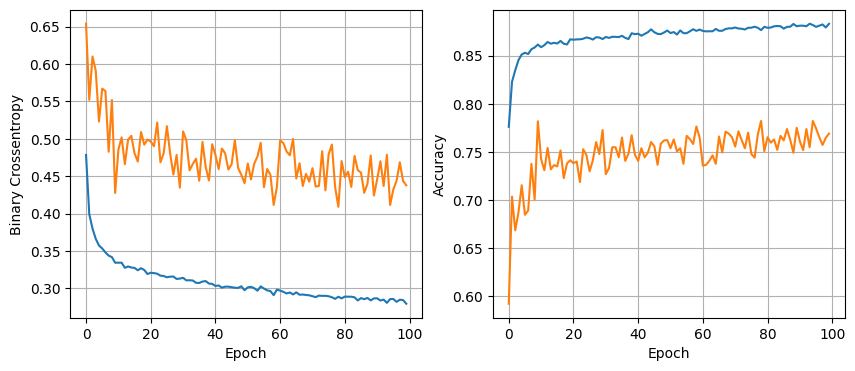

119/119 [==============================] - 0s 3ms/step - loss: 0.2888 - accuracy: 0.8830
Number of nodes: (64,), Dropout probability: 0.2 Learning_rate: 0.001 Batch size: 128


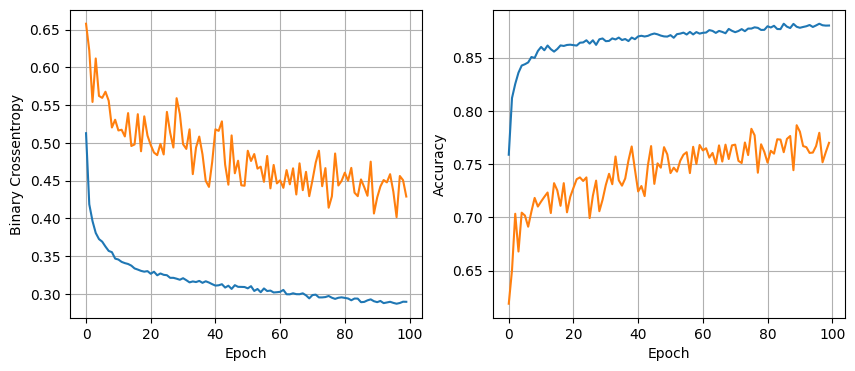

119/119 [==============================] - 0s 3ms/step - loss: 0.2889 - accuracy: 0.8835


In [ ]:
least_validation_loss = float('inf')
epochs = 100

for num_nodes in [16, 32, 64]:
  for dropout_probability in [0, 0.2]:
    for learning_rate in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"Number of nodes: {num_nodes}, Dropout probability: {dropout_probability} Learning_rate: {learning_rate} Batch size: {batch_size}")
        model, history = train_model(x_train, y_train, num_nodes, dropout_probability, learning_rate, batch_size, epochs)
        plot_history(history)

        validation_loss = model.evaluate(x_validation, y_validation)[0]
        if validation_loss < least_validation_loss:
          least_validation_loss = validation_loss
          least_loss_model = model